In [ ]:
#download colon cancer dataset
!gdown --id 1lJyMNhxVcTL7SCP6NuR5Aneph33eaSFP

In [ ]:
!unrar x "/content/colon_image_set.rar"

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [4]:
normal = glob('/content/colon_image_set/colon_image_sets/colon_n/*.jpeg')
affected = glob('/content/colon_image_set/colon_image_sets/colon_aca/*.jpeg')
dataset=normal[:]+affected[:]

from random import shuffle, seed; seed(10);
shuffle(dataset)

In [19]:
targetslabels={'colon_n':0,'colon_aca':1}
class colondataset(Dataset):
 def __init__(self,path):
  self.fpaths=path
  self.normalize = transforms.Normalize(mean=[0.485,
  0.456, 0.406],std=[0.229, 0.224, 0.225])
  from random import shuffle, seed; seed(10);
  shuffle(self.fpaths)
  self.targets =[targetslabels[fpath.split('/')[-2]] for fpath in self.fpaths]
 def __len__(self): return len(self.fpaths)
 def __getitem__(self, ix):
  f = self.fpaths[ix]
  target = self.targets[ix]
  im = (cv2.imread(f)[:,:,::-1])
  im = cv2.resize(im, (224,224))
  im = torch.tensor(im/255)
  im = im.permute(2,0,1)
  im = self.normalize(im)
  return im.float().to(device),torch.tensor([target]).float().to(device)
def get_data(train_idx,val_idx,data):
  train_sampler = SubsetRandomSampler(train_idx)
  val_sampler = SubsetRandomSampler(val_idx)
  trn_dl = DataLoader(data, batch_size=64, \
  drop_last = True,sampler=train_sampler)
  val_dl = DataLoader(data, batch_size=64,  \
  drop_last = True,sampler=val_sampler)
  return trn_dl, val_dl
def get_data():
  data=colondataset(dataset)
  trn_dl = DataLoader(data, batch_size=64, \
  drop_last = True,shuffle=True)
  return trn_dl

In [6]:
from torchsummary import summary
def build_model():
  model = models.vgg16(pretrained=True).to(device)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),nn.Linear(512, 128),nn.ReLU(),nn.Dropout(0.2),nn.Linear(128, 1),nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr= 1e-3)
  return model.to(device), loss_fn, optimizer
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()


In [7]:
import tqdm
from sklearn.model_selection import KFold
import numpy as np
data=colondataset(dataset)
splits = KFold(n_splits=4,shuffle=True,random_state=42)
folds_accs=[]
folds_splits=[]
for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
  print('Fold {}'.format(fold_idx + 1))
  trn_dl, val_dl = get_data(train_idx,val_idx,data)
  model, loss_fn, optimizer = build_model()
  summary(model,(3,224,224))
  train_losses, train_accuracies = [], []
  val_accuracies = []
  for epoch in range(10):
    print(f"  epoch {epoch + 1}/10")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
      x, y = batch
      batch_loss = train_batch(x, y, model, optimizer, \
      loss_fn)
      train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print("caalculate train acc...")
    for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
      x, y = batch
      is_correct = accuracy(x, y, model)
      train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print("caalculate val acc...")
    for ix, batch in enumerate(tqdm.tqdm(iter(val_dl))):
      x, y = batch
      val_is_correct = accuracy(x, y, model)
      val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    print("train_acc: %2.2f%% val_acc: %2.2f%%" %(train_epoch_accuracy*100,val_epoch_accuracy*100))
  print("fold mean train acc: %2.2f%% val acc: %2.2f%%" %(np.mean(train_accuracies)*100,np.mean(val_accuracies)*100))
  folds_accs.append([np.max(train_accuracies),np.max(val_accuracies)])
  folds_splits.append([train_idx,val_idx])

Fold 1


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train_acc: 88.25% val_acc: 86.66%
  epoch 2/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:22<00:00,  1.22s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train_acc: 89.29% val_acc: 88.50%
  epoch 3/10


100%|██████████| 117/117 [02:22<00:00,  1.22s/it]


caalculate train acc...


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 91.72% val_acc: 91.03%
  epoch 4/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 93.96% val_acc: 93.43%
  epoch 5/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train_acc: 95.03% val_acc: 94.03%
  epoch 6/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 95.41% val_acc: 94.83%
  epoch 7/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 95.66% val_acc: 95.27%
  epoch 8/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 95.65% val_acc: 95.27%
  epoch 9/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train_acc: 95.73% val_acc: 95.27%
  epoch 10/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 95.70% val_acc: 95.19%
fold mean train acc: 93.64% val acc: 92.95%
Fold 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-

100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 66.19% val_acc: 65.18%
  epoch 2/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train_acc: 73.18% val_acc: 72.32%
  epoch 3/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 79.47% val_acc: 78.21%
  epoch 4/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 83.40% val_acc: 82.97%
  epoch 5/10


100%|██████████| 117/117 [02:19<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 86.62% val_acc: 86.06%
  epoch 6/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 89.16% val_acc: 88.54%
  epoch 7/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:22<00:00,  1.22s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 90.60% val_acc: 90.22%
  epoch 8/10


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 91.93% val_acc: 91.27%
  epoch 9/10


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 92.88% val_acc: 92.23%
  epoch 10/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 93.28% val_acc: 92.95%
fold mean train acc: 84.67% val acc: 83.99%
Fold 3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-

100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 64.09% val_acc: 62.90%
  epoch 2/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 66.93% val_acc: 65.79%
  epoch 3/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 76.84% val_acc: 77.00%
  epoch 4/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 85.26% val_acc: 84.98%
  epoch 5/10


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 89.48% val_acc: 90.18%
  epoch 6/10


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 91.83% val_acc: 92.67%
  epoch 7/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 93.34% val_acc: 94.27%
  epoch 8/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 94.30% val_acc: 94.83%
  epoch 9/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 94.86% val_acc: 95.83%
  epoch 10/10


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:45<00:00,  1.17s/it]


train_acc: 95.25% val_acc: 96.27%
fold mean train acc: 85.22% val acc: 85.47%
Fold 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-

100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 74.95% val_acc: 74.20%
  epoch 2/10


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


train_acc: 93.48% val_acc: 93.39%
  epoch 3/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:47<00:00,  1.21s/it]


train_acc: 93.19% val_acc: 93.03%
  epoch 4/10


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 94.31% val_acc: 94.51%
  epoch 5/10


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 94.63% val_acc: 95.11%
  epoch 6/10


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


train_acc: 95.26% val_acc: 95.43%
  epoch 7/10


100%|██████████| 117/117 [02:17<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:45<00:00,  1.18s/it]


train_acc: 95.67% val_acc: 95.35%
  epoch 8/10


100%|██████████| 117/117 [02:19<00:00,  1.19s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.18s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 95.78% val_acc: 95.15%
  epoch 9/10


100%|██████████| 117/117 [02:21<00:00,  1.21s/it]


caalculate train acc...


100%|██████████| 117/117 [02:20<00:00,  1.20s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


train_acc: 95.83% val_acc: 95.11%
  epoch 10/10


100%|██████████| 117/117 [02:17<00:00,  1.18s/it]


caalculate train acc...


100%|██████████| 117/117 [02:18<00:00,  1.19s/it]


caalculate val acc...


100%|██████████| 39/39 [00:46<00:00,  1.18s/it]

train_acc: 95.79% val_acc: 95.19%
fold mean train acc: 92.89% val acc: 92.65%


In [8]:
import pickle
with open('folds_accs.list','wb') as f:
  pickle.dump(folds_accs,f)
  f.close
with open('folds_splits.list','wb') as f:
  pickle.dump(folds_splits,f)
  f.close

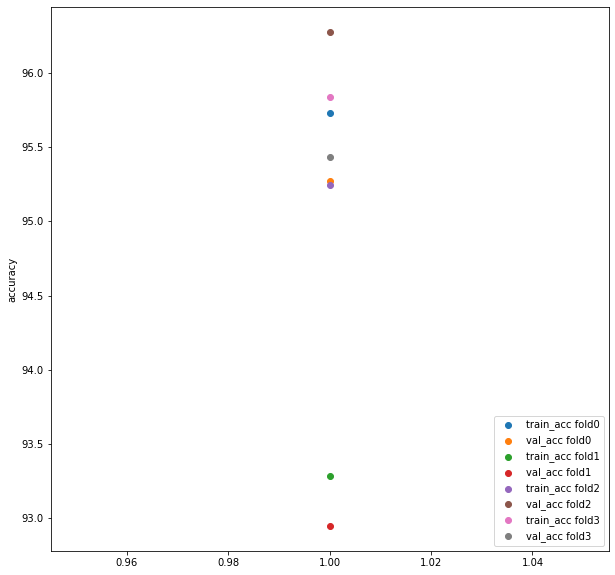

In [17]:
epochs=1
plt.figure(figsize=(10,10))
for i in range(4):
  plt.scatter(epochs,folds_accs[i][0]*100,label='train_acc fold'+str(i))
  plt.scatter(epochs,folds_accs[i][1]*100,label='val_acc fold'+str(i))
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.show()

In [21]:
trn_dl = get_data()
model, loss_fn, optimizer = build_model()
summary(model,(3,224,224))
train_losses, train_accuracies = [], []
for epoch in range(10):
  print(f"  epoch {epoch + 1}/10")
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, \
    loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print("calculate train acc...")
  for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  print("train_acc: %2.2f%% " %(train_epoch_accuracy*100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

100%|██████████| 156/156 [03:10<00:00,  1.22s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


train_acc: 51.69% 
  epoch 2/10


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


train_acc: 70.21% 
  epoch 3/10


100%|██████████| 156/156 [03:07<00:00,  1.20s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


train_acc: 86.71% 
  epoch 4/10


100%|██████████| 156/156 [03:07<00:00,  1.20s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


train_acc: 91.85% 
  epoch 5/10


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.19s/it]


train_acc: 93.94% 
  epoch 6/10


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


calculate train acc...


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


train_acc: 94.67% 
  epoch 7/10


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


calculate train acc...


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


train_acc: 95.10% 
  epoch 8/10


100%|██████████| 156/156 [03:06<00:00,  1.20s/it]


calculate train acc...


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


train_acc: 95.19% 
  epoch 9/10


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


calculate train acc...


100%|██████████| 156/156 [03:04<00:00,  1.19s/it]


train_acc: 95.35% 
  epoch 10/10


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


calculate train acc...


100%|██████████| 156/156 [03:05<00:00,  1.19s/it]

train_acc: 95.39% 


In [22]:
import pickle
with open('/content/coloncancerclassification.model','wb') as f:
  pickle.dump(model,f)
  f.close()
with open('/content/coloncancerclassificationCPU.model','wb') as f:
  pickle.dump(model.to('cpu'),f)
  f.close()

In [ ]:
!gdown 1z5d2MAggTjVFKug4npdiWp4wK1ydB6CS
!gdown 19ZynLm4plhY_K2jTY3eYIkMuNrSYO2UK
import pickle
if device=='cpu':
  with open('/content/coloncancerclassificationCPU.model','rb')as f:
    loaded_model=pickle.load(f)
    f.close()
else:
  with open('/content/coloncancerclassification.model','rb')as f:
    loaded_model=pickle.load(f)
    f.close()

100%|██████████| 10000/10000 [04:05<00:00, 40.81it/s]


correct predictions on data set (10000 image)= 9540 
total accuracy= 95.40%


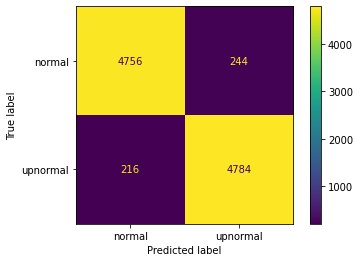

In [29]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tqdm
labelstargets={0:'colon_n',1:'colon_aca'}
norm_upnorm={'colon_n':'normal','colon_aca':'upnormal'}
normalize = transforms.Normalize(mean=[0.485,
  0.456, 0.406],std=[0.229, 0.224, 0.225])
correcte=0
true=[]
preds=[]
for i in tqdm.tqdm(dataset):
  im = (cv2.imread(i)[:,:,::-1])
  im = cv2.resize(im, (224,224))
  im = torch.tensor(im/255)
  im = im.permute(2,0,1)
  im = normalize(im)
  target=i.split('/')[-2]
  pred=loaded_model(im.float().to(device)[None])
  if pred>0.5:
    pred=1
  else:
    pred=0
  if target==labelstargets[pred]:
    correcte+=1
  true.append(target)
  preds.append(labelstargets[pred])
print("correct predictions on data set (%d image)= %d \ntotal accuracy= %2.2f%%"%(len(dataset),correcte,(correcte/len(dataset))*100))
conf_mat=confusion_matrix(true,preds,labels=['colon_n','colon_aca'])
disp=ConfusionMatrixDisplay(conf_mat,display_labels=['normal','upnormal'])
disp.plot()
